In [323]:
import wandb
import pandas as pd
import plotnine as p9
import numpy as np
import polars as pl
import scipy
import scipy.stats as stats
import scipy.sparse as sparse
import xgboost as xgb
from dotenv import load_dotenv
load_dotenv()

True

# Load the data

In [242]:
titles = pl.read_csv(
    "data/title.basics.tsv",
    separator="\t",
    null_values="\\N",
    quote_char=None,
    schema_overrides={"endYear": int},
    infer_schema=True,
)
types = pl.Enum(titles.select("titleType").unique())
titles = titles.filter(pl.col("titleType").str.contains("(?i)movie")).with_columns(
    pl.col("titleType").cast(types),
    pl.col("genres").str.split(","),
)
ratings = pl.read_csv(
    "data/title.ratings.tsv",
    separator="\t",
)
principals = pl.read_csv("data/title.principals.tsv", separator="\t")
names = pl.read_csv(
    "data/name.basics.tsv",
    separator="\t",
    null_values="\\N",
)

In [29]:
titles.head()

tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
str,enum,str,str,i64,i64,i64,i64,list[str]
"""tt0000009""","""movie""","""Miss Jerry""","""Miss Jerry""",0,1894,null,45,"[""Romance""]"
"""tt0000147""","""movie""","""The Corbett-Fitzsimmons Fight""","""The Corbett-Fitzsimmons Fight""",0,1897,null,100,"[""Documentary"", ""News"", ""Sport""]"
"""tt0000502""","""movie""","""Bohemios""","""Bohemios""",0,1905,null,100,null
"""tt0000574""","""movie""","""The Story of the Kelly Gang""","""The Story of the Kelly Gang""",0,1906,null,70,"[""Action"", ""Adventure"", ""Biography""]"
"""tt0000591""","""movie""","""The Prodigal Son""","""L'enfant prodigue""",0,1907,null,90,"[""Drama""]"


<div><style>
.dataframe > thead > tr,
.dataframe > tbody > tr {
  text-align: right;
  white-space: pre-wrap;
}
</style>
<small>shape: (10, 1)</small><table border="1" class="dataframe"><thead><tr><th>titleType</th></tr><tr><td>str</td></tr></thead><tbody><tr><td>&quot;short&quot;</td></tr><tr><td>&quot;tvSpecial&quot;</td></tr><tr><td>&quot;tvShort&quot;</td></tr><tr><td>&quot;tvEpisode&quot;</td></tr><tr><td>&quot;tvSeries&quot;</td></tr><tr><td>&quot;tvMovie&quot;</td></tr><tr><td>&quot;movie&quot;</td></tr><tr><td>&quot;videoGame&quot;</td></tr><tr><td>&quot;video&quot;</td></tr><tr><td>&quot;tvMiniSeries&quot;</td></tr></tbody></table></div>

## Split the data into training set and test set.
We perform all EDA on training set too.
We first inner join on the ratings, to filter out titles which have no rating.

In [153]:
test_proportion = 0.1
title_ratings = titles.join(ratings, on="tconst", how="inner")

train_test = np.where(
    np.random.default_rng(42).random(len(title_ratings)) < test_proportion,
    "test",
    "train",
)
title_ratings = title_ratings.with_columns(train_test=train_test)

title_ratings_dict = {
    key[0]: df
    for key, df in title_ratings.partition_by("train_test", as_dict=True).items()
}

for split in title_ratings_dict.keys():
    title_ratings_dict[split] = title_ratings_dict[split].with_columns(
        i_tconst=pl.int_range(pl.len())
    )
# index columns for generating sparse matrices

In [33]:
title_ratings_train.select("averageRating").describe()

statistic,averageRating
str,f64
"""count""",332717.0
"""null_count""",0.0
"""mean""",6.230402
"""std""",1.365084
"""min""",1.0
"""25%""",5.4
"""50%""",6.3
"""75%""",7.2
"""max""",10.0


<div><style>
.dataframe > thead > tr,
.dataframe > tbody > tr {
  text-align: right;
  white-space: pre-wrap;
}
</style>
<small>shape: (9, 2)</small><table border="1" class="dataframe"><thead><tr><th>statistic</th><th>averageRating</th></tr><tr><td>str</td><td>f64</td></tr></thead><tbody><tr><td>&quot;count&quot;</td><td>332717.0</td></tr><tr><td>&quot;null_count&quot;</td><td>0.0</td></tr><tr><td>&quot;mean&quot;</td><td>6.230402</td></tr><tr><td>&quot;std&quot;</td><td>1.365084</td></tr><tr><td>&quot;min&quot;</td><td>1.0</td></tr><tr><td>&quot;25%&quot;</td><td>5.4</td></tr><tr><td>&quot;50%&quot;</td><td>6.3</td></tr><tr><td>&quot;75%&quot;</td><td>7.2</td></tr><tr><td>&quot;max&quot;</td><td>10.0</td></tr></tbody></table></div>

can use age of actors to differentiate actor popularity 

In [35]:
principals.get_column("category").value_counts(sort=True)

category,count
str,u32
"""actor""",20502447
"""actress""",15325804
"""self""",12124895
"""writer""",10365715
"""director""",7417673
…,…
"""composer""",2824963
"""production_designer""",1049464
"""casting_director""",1008036


In [229]:
actors = principals.filter(pl.col("category").is_in(("actor", "actress")))

In [253]:
title_ratings_actors = {
    key: (
        title_ratings_dict[key]
        .select(["tconst", "i_tconst", "averageRating", "numVotes"])
        .join(actors, how="inner", on="tconst")
        .join(names, how="inner", on="nconst")
    )
    for key in title_ratings_dict.keys()
}
# actors who were in films listed (in train/test set) thogether with rating and numVotes of the films

In [231]:
title_ratings_actors["train"].head()

tconst,averageRating,numVotes,ordering,nconst,category,job,characters,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
str,f64,i64,i64,str,str,str,str,str,i64,i64,str,str
"""tt0023926""",6.8,2714,6,"""nm0000001""","""actor""","""\N""","""[""Fred Astaire""]""","""Fred Astaire""",1899,1987,"""actor,miscellaneous,producer""","""tt0072308,tt0050419,tt0053137,…"
"""tt0025164""",7.4,8740,1,"""nm0000001""","""actor""","""\N""","""[""Guy Holden""]""","""Fred Astaire""",1899,1987,"""actor,miscellaneous,producer""","""tt0072308,tt0050419,tt0053137,…"
"""tt0026942""",7.0,3699,2,"""nm0000001""","""actor""","""\N""","""[""Huck Haines""]""","""Fred Astaire""",1899,1987,"""actor,miscellaneous,producer""","""tt0072308,tt0050419,tt0053137,…"
"""tt0027125""",7.7,20890,1,"""nm0000001""","""actor""","""\N""","""[""Jerry Travers""]""","""Fred Astaire""",1899,1987,"""actor,miscellaneous,producer""","""tt0072308,tt0050419,tt0053137,…"
"""tt0027630""",7.1,4772,1,"""nm0000001""","""actor""","""\N""","""[""Bake Baker""]""","""Fred Astaire""",1899,1987,"""actor,miscellaneous,producer""","""tt0072308,tt0050419,tt0053137,…"


In [249]:
actors_ranking = (
    title_ratings_actors["train"]
    .group_by("primaryName", "nconst")
    .agg(
        averageRating=(pl.col("averageRating") * pl.col("numVotes")).sum()
        / pl.col("numVotes").sum(),
        numStars=(pl.col("averageRating") * pl.col("numVotes")).sum(),
        stdevRating=((pl.col("averageRating") ** 2) * pl.col("numVotes")).sum()
        / pl.col("numVotes").sum(),  # mean X^2
        numVotes=pl.col("numVotes").sum(),
        numFilms=pl.len(),
    )
    .with_columns(
        stdevRating=(pl.col("stdevRating") - pl.col("averageRating") ** 2).sqrt(),
    )
    .sort("numStars", descending=True)
    .with_columns(i_nconst=pl.int_range(pl.len()))
)
# get actors 'average rating' based on the weighted average of the films they have been in weighted by the votes for the film
# numVotes is a kind of popularity ranking - how many people have seen that actor
# one might want to calculate the averageRating * numVotes - ie total stars received by actor to combine popularity with Rating
# for average rating / num votes how to handle missing data ( in test set but not in training)
# we cannot directly use this information as its 'leaking' the label data - unless eg we exclude the current film from the actor rating...

actors_ranking[:40]

primaryName,nconst,averageRating,numStars,stdevRating,numVotes,numFilms,i_nconst
str,str,f64,f64,f64,i64,u32,i64
"""Scarlett Johansson""","""nm0424060""",7.617642,1.7133e8,0.759255,22491194,57,0
"""Christian Bale""","""nm0000288""",8.163657,1.6713e8,0.811616,20472096,50,1
"""Samuel L. Jackson""","""nm0000168""",7.383264,1.5193e8,0.959332,20578071,110,2
"""Mark Ruffalo""","""nm0749263""",7.870815,1.4604e8,0.581565,18554838,52,3
"""Brad Pitt""","""nm0000093""",7.79803,1.4145e8,0.73033,18138982,47,4
…,…,…,…,…,…,…,…
"""Ralph Fiennes""","""nm0000146""",7.594167,7.2487e7,0.927332,9545137,68,35
"""Jennifer Lawrence""","""nm2225369""",7.203923,7.2161e7,0.593113,10016950,28,36
"""Sala Baker""","""nm1019674""",8.804468,7.1836e7,0.416366,8159020,13,37


In [250]:
cutoff = 10_000
actors_ranking_shortlist = actors_ranking[:cutoff].select(
    ["primaryName", "nconst", "i_nconst"]
)

In [320]:
actors_ranking_shortlist.get_columns("primaryName")

primaryName,nconst,i_nconst
str,str,i64
"""Scarlett Johansson""","""nm0424060""",0
"""Christian Bale""","""nm0000288""",1
"""Samuel L. Jackson""","""nm0000168""",2
"""Mark Ruffalo""","""nm0749263""",3
"""Brad Pitt""","""nm0000093""",4


In [246]:
title_ratings_actors["train"].head()

tconst,averageRating,numVotes,ordering,nconst,category,job,characters,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
str,f64,i64,i64,str,str,str,str,str,i64,i64,str,str
"""tt0023926""",6.8,2714,6,"""nm0000001""","""actor""","""\N""","""[""Fred Astaire""]""","""Fred Astaire""",1899,1987,"""actor,miscellaneous,producer""","""tt0072308,tt0050419,tt0053137,…"
"""tt0025164""",7.4,8740,1,"""nm0000001""","""actor""","""\N""","""[""Guy Holden""]""","""Fred Astaire""",1899,1987,"""actor,miscellaneous,producer""","""tt0072308,tt0050419,tt0053137,…"
"""tt0026942""",7.0,3699,2,"""nm0000001""","""actor""","""\N""","""[""Huck Haines""]""","""Fred Astaire""",1899,1987,"""actor,miscellaneous,producer""","""tt0072308,tt0050419,tt0053137,…"
"""tt0027125""",7.7,20890,1,"""nm0000001""","""actor""","""\N""","""[""Jerry Travers""]""","""Fred Astaire""",1899,1987,"""actor,miscellaneous,producer""","""tt0072308,tt0050419,tt0053137,…"
"""tt0027630""",7.1,4772,1,"""nm0000001""","""actor""","""\N""","""[""Bake Baker""]""","""Fred Astaire""",1899,1987,"""actor,miscellaneous,producer""","""tt0072308,tt0050419,tt0053137,…"


In [256]:
title_actors_rated_encoded = {
    key: title_ratings_actors[key]
    .select(["tconst", "i_tconst", "ordering", "nconst", "primaryName", "birthYear"])
    .join(actors_ranking_shortlist, on="nconst", how="inner")
    for key in title_ratings_dict.keys()
}
title_actors_rated_encoded["train"].head()

tconst,i_tconst,ordering,nconst,primaryName,birthYear,primaryName_right,i_nconst
str,i64,i64,str,str,i64,str,i64
"""tt0023926""",5925,6,"""nm0000001""","""Fred Astaire""",1899,"""Fred Astaire""",6039
"""tt0025164""",6582,1,"""nm0000001""","""Fred Astaire""",1899,"""Fred Astaire""",6039
"""tt0026942""",7566,2,"""nm0000001""","""Fred Astaire""",1899,"""Fred Astaire""",6039
"""tt0027125""",7672,1,"""nm0000001""","""Fred Astaire""",1899,"""Fred Astaire""",6039
"""tt0027630""",7979,1,"""nm0000001""","""Fred Astaire""",1899,"""Fred Astaire""",6039


In [235]:
title_actors_rated_short = (
    title_ratings_actors["train"]
    .select(pl.exclude(["primaryName", "averageRating", "numVotes"]))
    .join(actors_ranking_shortlist, on="nconst", how="inner")
)
print(title_actors_rated_short.head())
title_actors_rated_short.shape

shape: (5, 16)
┌───────────┬──────────┬───────────┬──────────┬───┬───────────┬─────────────┬──────────┬──────────┐
│ tconst    ┆ ordering ┆ nconst    ┆ category ┆ … ┆ numStars  ┆ stdevRating ┆ numVotes ┆ numFilms │
│ ---       ┆ ---      ┆ ---       ┆ ---      ┆   ┆ ---       ┆ ---         ┆ ---      ┆ ---      │
│ str       ┆ i64      ┆ str       ┆ str      ┆   ┆ f64       ┆ f64         ┆ i64      ┆ u32      │
╞═══════════╪══════════╪═══════════╪══════════╪═══╪═══════════╪═════════════╪══════════╪══════════╡
│ tt0023926 ┆ 6        ┆ nm0000001 ┆ actor    ┆ … ┆ 2097812.6 ┆ 0.409603    ┆ 295801   ┆ 43       │
│ tt0025164 ┆ 1        ┆ nm0000001 ┆ actor    ┆ … ┆ 2097812.6 ┆ 0.409603    ┆ 295801   ┆ 43       │
│ tt0026942 ┆ 2        ┆ nm0000001 ┆ actor    ┆ … ┆ 2097812.6 ┆ 0.409603    ┆ 295801   ┆ 43       │
│ tt0027125 ┆ 1        ┆ nm0000001 ┆ actor    ┆ … ┆ 2097812.6 ┆ 0.409603    ┆ 295801   ┆ 43       │
│ tt0027630 ┆ 1        ┆ nm0000001 ┆ actor    ┆ … ┆ 2097812.6 ┆ 0.409603    ┆ 295801 

(247585, 16)

In [236]:
title_actors_rated_short.columns

['tconst',
 'ordering',
 'nconst',
 'category',
 'job',
 'characters',
 'birthYear',
 'deathYear',
 'primaryProfession',
 'knownForTitles',
 'primaryName',
 'averageRating',
 'numStars',
 'stdevRating',
 'numVotes',
 'numFilms']

In [241]:
print(
    f"getting {cutoff:,} actors only covers {title_actors_rated_short.get_column('tconst').n_unique():,} films of {len(title_ratings_dict['train']):,}"
)

getting 10,000 actors only covers 96,876 films of 332,717


In [226]:
actors_rated.filter(pl.col("tconst") == "tt0076759").head(50)

tconst,ordering,nconst,category,job,characters
str,i64,str,str,str,str
"""tt0076759""",1,"""nm0000434""","""actor""","""\N""","""[""Luke Skywalk…"
"""tt0076759""",2,"""nm0000148""","""actor""","""\N""","""[""Han Solo""]"""
"""tt0076759""",3,"""nm0000402""","""actress""","""\N""","""[""Princess Lei…"
"""tt0076759""",4,"""nm0000027""","""actor""","""\N""","""[""Ben Obi-Wan …"
"""tt0076759""",5,"""nm0001088""","""actor""","""\N""","""[""Grand Moff T…"
"""tt0076759""",6,"""nm0000355""","""actor""","""\N""","""[""C-3PO""]"""
"""tt0076759""",7,"""nm0048652""","""actor""","""\N""","""[""R2-D2""]"""
"""tt0076759""",8,"""nm0562679""","""actor""","""\N""","""[""Chewbacca""]"""
"""tt0076759""",9,"""nm0001190""","""actor""","""\N""","""[""Darth Vader""…"


In [150]:
principals.get_column("category").value_counts(sort=True)

category,count
str,u32
"""actor""",20502447
"""actress""",15325804
"""self""",12124895
"""writer""",10365715
"""director""",7417673
"""producer""",6481356
"""editor""",4508848
"""cinematographe…",3450974
"""composer""",2824963


In [106]:
x_cols = ["titleType", "isAdult", "startYear", "runtimeMinutes"]

#Plan
1. load relevant data (title/rating/principals)
2. split
3. EDA
4. xgboost model
5. linear model



## Modelling

## Sparsifying data
Data can be naturally mapped from exploded format to row/column/value COO sparse matrix

In [277]:
def explode_col(df, col):
    explode = df.select(["tconst", "i_tconst", col]).drop_nulls(col).explode(col)
    return explode


def add_index_map(df, col, col_map):
    df_new = df.with_columns(
        pl.col(col).replace(col_map).cast(pl.Int64).alias(f"i_{col}")
    )
    return df_new


def make_hot_coo_array(
    df,
    row_col,
    col_col,
    n_rows=None,
    n_cols=None,
    value_col=None,
):
    rows = df.get_column(row_col).to_numpy()
    cols = df.get_column(col_col).to_numpy()
    coords = (rows, cols)
    if value_col is None:
        values = [1] * len(rows)
    else:
        values = df.get_column(value_col).to_numpy()
    if not n_rows:
        n_rows = rows.max() + 1
    if not n_cols:
        n_cols = cols.max() + 1

    shape = (n_rows, n_cols)

    coo_array = sparse.coo_array((values, (rows, cols)), shape)
    return coo_array

In [339]:
tgr_explode = {
    key: explode_col(title_ratings_dict[key], "genres")
    for key in title_ratings_dict.keys()
}
# explode data
genres_count = (
    tgr_explode["train"]
    .get_column("genres")
    .value_counts(sort=True)
    .with_columns(i_genres=pl.int_range(pl.len()))
)
# add index to genres
genres_map = dict(genres_count.select(["genres", "i_genres"]).iter_rows())
tgr_explode = {
    key: add_index_map(tgr_explode[key], "genres", genres_map)
    for key in tgr_explode.keys()
}
# make sparse array
g_sps = {
    key: make_hot_coo_array(tgr_explode[key], "i_tconst", "i_genres", n_cols=(tgr_explode["train"]["i_genres"].max()+1))
    for key in tgr_explode.keys()
}


tgr_explode["test"].head()

genres_map

{'Drama': 0,
 'Comedy': 1,
 'Documentary': 2,
 'Romance': 3,
 'Action': 4,
 'Crime': 5,
 'Thriller': 6,
 'Horror': 7,
 'Adventure': 8,
 'Family': 9,
 'Mystery': 10,
 'Biography': 11,
 'History': 12,
 'Fantasy': 13,
 'Music': 14,
 'Sci-Fi': 15,
 'Musical': 16,
 'War': 17,
 'Animation': 18,
 'Western': 19,
 'Sport': 20,
 'Adult': 21,
 'Film-Noir': 22,
 'News': 23,
 'Reality-TV': 24,
 'Talk-Show': 25,
 'Game-Show': 26}

In [108]:
x_cols

['titleType', 'isAdult', 'startYear', 'runtimeMinutes']

In [175]:
data_X_sp = {
    key: sparse.coo_array(title_ratings_dict[key][x_cols[1:]].to_numpy())
    for key in title_ratings_dict.keys()
}

In [124]:
train_sp.shape

(332717, 65)

In [269]:
actor_sps["train"].shape

(332712, 10000)

In [272]:
title_ratings_dict["train"].get_column("i_tconst").max()

332716

In [270]:
title_actors_rated_encoded["train"].get_column("i_tconst").describe()

statistic,value
str,f64
"""count""",247585.0
"""null_count""",0.0
"""mean""",134942.504231
"""std""",93500.182171
"""min""",25.0
"""25%""",53961.0
"""50%""",120289.0
"""75%""",209879.0
"""max""",332711.0


In [278]:
actor_sps = {
    key: make_hot_coo_array(
        title_actors_rated_encoded[key],
        "i_tconst",
        "i_nconst",
        n_rows=title_ratings_dict[key].get_column("i_tconst").max() + 1,
        value_col="ordering",
    )
    for key in title_actors_rated_encoded.keys()
}

In [330]:
actor_names = actors_ranking_shortlist.get_column("primaryName").to_list()
actors_ranking_shortlist.filter(pl.col("primaryName") == "Chris Williams")
actor_names[2805] += "_1"
actor_names[5954] += "_2"

In [334]:
col_names = x_cols[1:] + list(genres_map.keys()) + actor_names



In [338]:
g_sps["train"].shape

(332717, 27)

In [340]:

data_sps = {
    key: sparse.hstack((data_X_sp[key], g_sps[key], actor_sps[key]))
    for key in data_X_sp.keys()
}


In [341]:
dmatrices = {
    key: xgb.DMatrix(
        data_sps[key],
        label=title_ratings_dict[key]["averageRating"],
        weight=title_ratings_dict[key]["numVotes"],
        feature_names = col_names
    )
    for key in title_ratings_dict.keys()
}

In [207]:
bst.attributes()

{}

In [359]:
from wandb.xgboost import WandbCallback

num_round = 2000
param = {"max_depth": 12, "gamma": 1, "objective": "reg:squarederror"}
etas = [
    0.010, 0.008, 0.006
]
dataset = ""
#all_evals2 = []
evallist = [(dmatrices[key], key) for key in dmatrices.keys()]
for eta in etas:
    param["eta"] = eta
    wandb.init("IMDB_xgboost", config=param)
    wandb.config["num_round"] = num_round 
    evals_result = {}
    bst = xgb.train(
        param, dmatrices["train"], num_round, evallist, evals_result=evals_result,
        callbacks=[WandbCallback(log_model=False)]
    )
    evals_result.update(param)
    evals_result["num_round"] = num_round
    all_evals2.append(evals_result)
wandb.finish()

/Users/seanviolante/miniforge3/envs/ML/lib/python3.11/site-packages/xgboost/core.py:723: FutureWarning: Pass `evals` as keyword args.


[0]	train-rmse:1.06725	test-rmse:1.05852
[1]	train-rmse:1.06127	test-rmse:1.05501
[2]	train-rmse:1.05551	test-rmse:1.05193
[3]	train-rmse:1.04978	test-rmse:1.04907
[4]	train-rmse:1.04406	test-rmse:1.04568
[5]	train-rmse:1.03853	test-rmse:1.04276
[6]	train-rmse:1.03303	test-rmse:1.04006
[7]	train-rmse:1.02750	test-rmse:1.03646
[8]	train-rmse:1.02216	test-rmse:1.03390
[9]	train-rmse:1.01685	test-rmse:1.03130
[10]	train-rmse:1.01150	test-rmse:1.02801
[11]	train-rmse:1.00639	test-rmse:1.02537
[12]	train-rmse:1.00131	test-rmse:1.02273
[13]	train-rmse:0.99634	test-rmse:1.02017
[14]	train-rmse:0.99141	test-rmse:1.01773
[15]	train-rmse:0.98660	test-rmse:1.01525
[16]	train-rmse:0.98159	test-rmse:1.01209
[17]	train-rmse:0.97687	test-rmse:1.00963
[18]	train-rmse:0.97210	test-rmse:1.00708
[19]	train-rmse:0.96726	test-rmse:1.00470
[20]	train-rmse:0.96271	test-rmse:1.00229
[21]	train-rmse:0.95813	test-rmse:0.99983
[22]	train-rmse:0.95346	test-rmse:0.99761
[23]	train-rmse:0.94901	test-rmse:0.99523
[2

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test-rmse,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train-rmse,█▅▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,1999


/Users/seanviolante/miniforge3/envs/ML/lib/python3.11/site-packages/xgboost/core.py:723: FutureWarning: Pass `evals` as keyword args.


[0]	train-rmse:1.06844	test-rmse:1.05920
[1]	train-rmse:1.06363	test-rmse:1.05638
[2]	train-rmse:1.05900	test-rmse:1.05390
[3]	train-rmse:1.05431	test-rmse:1.05111
[4]	train-rmse:1.04978	test-rmse:1.04868
[5]	train-rmse:1.04526	test-rmse:1.04645
[6]	train-rmse:1.04077	test-rmse:1.04421
[7]	train-rmse:1.03627	test-rmse:1.04128
[8]	train-rmse:1.03191	test-rmse:1.03916
[9]	train-rmse:1.02755	test-rmse:1.03704
[10]	train-rmse:1.02318	test-rmse:1.03418
[11]	train-rmse:1.01892	test-rmse:1.03194
[12]	train-rmse:1.01475	test-rmse:1.02976
[13]	train-rmse:1.01058	test-rmse:1.02753
[14]	train-rmse:1.00651	test-rmse:1.02537
[15]	train-rmse:1.00231	test-rmse:1.02271
[16]	train-rmse:0.99833	test-rmse:1.02076
[17]	train-rmse:0.99441	test-rmse:1.01878
[18]	train-rmse:0.99049	test-rmse:1.01679
[19]	train-rmse:0.98645	test-rmse:1.01423
[20]	train-rmse:0.98260	test-rmse:1.01224
[21]	train-rmse:0.97877	test-rmse:1.01019
[22]	train-rmse:0.97483	test-rmse:1.00823
[23]	train-rmse:0.97105	test-rmse:1.00622
[2

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test-rmse,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train-rmse,█▆▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,1999


/Users/seanviolante/miniforge3/envs/ML/lib/python3.11/site-packages/xgboost/core.py:723: FutureWarning: Pass `evals` as keyword args.


[0]	train-rmse:1.06964	test-rmse:1.05988
[1]	train-rmse:1.06607	test-rmse:1.05784
[2]	train-rmse:1.06249	test-rmse:1.05574
[3]	train-rmse:1.05902	test-rmse:1.05387
[4]	train-rmse:1.05556	test-rmse:1.05200
[5]	train-rmse:1.05208	test-rmse:1.04992
[6]	train-rmse:1.04869	test-rmse:1.04827
[7]	train-rmse:1.04531	test-rmse:1.04658
[8]	train-rmse:1.04191	test-rmse:1.04437
[9]	train-rmse:1.03861	test-rmse:1.04263
[10]	train-rmse:1.03528	test-rmse:1.04098
[11]	train-rmse:1.03198	test-rmse:1.03936
[12]	train-rmse:1.02867	test-rmse:1.03719
[13]	train-rmse:1.02546	test-rmse:1.03565
[14]	train-rmse:1.02224	test-rmse:1.03408
[15]	train-rmse:1.01899	test-rmse:1.03198
[16]	train-rmse:1.01583	test-rmse:1.03026
[17]	train-rmse:1.01269	test-rmse:1.02861
[18]	train-rmse:1.00962	test-rmse:1.02700
[19]	train-rmse:1.00654	test-rmse:1.02539
[20]	train-rmse:1.00340	test-rmse:1.02337
[21]	train-rmse:1.00040	test-rmse:1.02184
[22]	train-rmse:0.99743	test-rmse:1.02040
[23]	train-rmse:0.99446	test-rmse:1.01883
[2

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test-rmse,█▆▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train-rmse,█▆▅▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,1999


In [347]:
zz = bst.get_score()

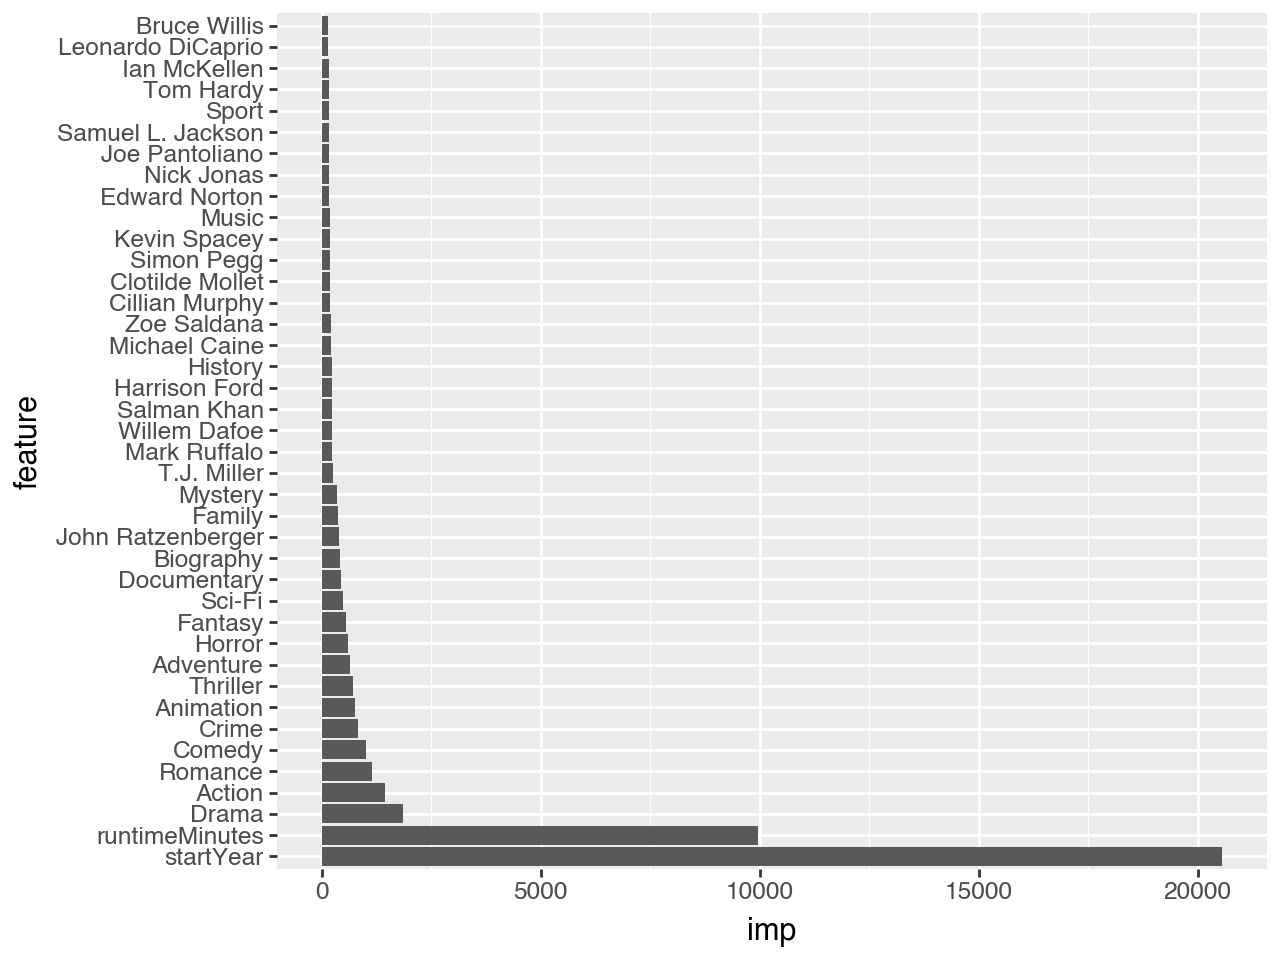

In [358]:
imp_data = pl.DataFrame({"feature" :zz.keys(), "imp": zz.values()}).sort("imp", descending=True)[:40].with_columns(feature=pl.col("feature").cast(pl.Categorical))
p9.ggplot(imp_data, p9.aes(x="feature", y="imp")) + p9.geom_bar(stat="identity")+p9.coord_flip()

In [343]:
xgb.plot_importance(bst,)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

In [286]:
df_evals2 = pl.DataFrame(
    {
        "eta": etas,
        "train": [all_evals2[i_eta]["train"]["rmse"][-1] for i_eta in range(len(etas))],
        "test": [all_evals2[i_eta]["test"]["rmse"][-1] for i_eta in range(len(etas))],
    }
)

In [308]:
df_evals2

eta,train,test
f64,f64,f64
0.01,0.762241,0.848844
0.008,0.776108,0.850467
0.006,0.791996,0.852114
0.004,0.812599,0.855574
0.002,0.843649,0.86223


add some form of logging
add weights& biases
add results and conclusions

In [295]:
df_comb = pl.concat((
    df_evals.with_columns(pl.lit("basic|genres").alias("inputs")),
    df_evals1.with_columns(pl.lit("basic|genres|actors").alias("inputs")),
    df_evals2.with_columns(pl.lit("basic|genres|actors").alias("inputs"))
))

In [301]:
df_comb.write_csv("data/results.csv")

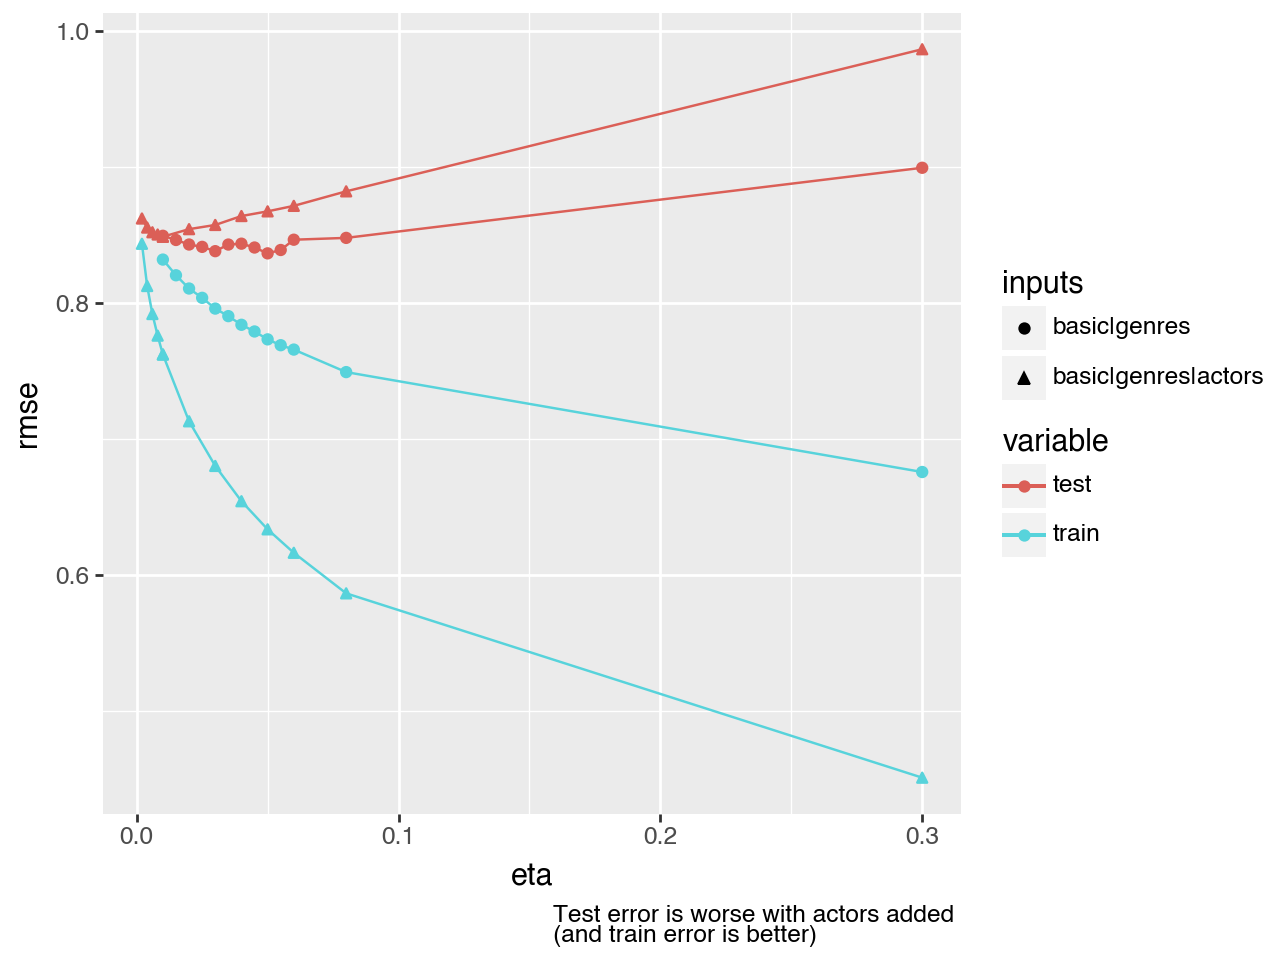

In [309]:
plot_data = df_comb.unpivot(index=["inputs","eta"])
(p9.ggplot(plot_data,
          p9.aes(x="eta", y="value", colour="variable", shape="inputs")) 
          + p9.geom_line() + p9.geom_point()
          +p9.labs(y="rmse",caption="Test error is worse with actors added \n(and train error is better)\nsuggesting overfitting")
)

In [293]:
df_evals1

eta,train,test
f64,f64,f64
0.3,0.451056,0.986716
0.08,0.586608,0.882214
0.06,0.616424,0.871532
0.05,0.633682,0.867501
0.04,0.65435,0.864051
0.03,0.680297,0.857494
0.02,0.713126,0.85441
0.01,0.762241,0.848844


In [ ]:
tgr_gp = (
    tgr_explode.group_by("genres")
    .agg(
        (pl.col("averageRating") * pl.col("numVotes")).sum() / pl.col("numVotes").sum(),
        pl.col("numVotes").sum(),
        (
            ((pl.col("averageRating") ** 2) * pl.col("numVotes")).sum()
            / pl.col("numVotes").sum()
        ).alias("wss"),
    )
    .with_columns((pl.col("wss") - pl.col("averageRating") ** 2).sqrt().alias("std"))
    .with_columns(
        (pl.col("std") / pl.col("numVotes").sqrt()).alias("std_err")
    )  # todo check
    .sort("numVotes", descending=True)
    .with_columns(index=pl.int_range(pl.len()))
    .with_columns(genres=pl.col("genres").cast(pl.Categorical()))
)
tgr_gp

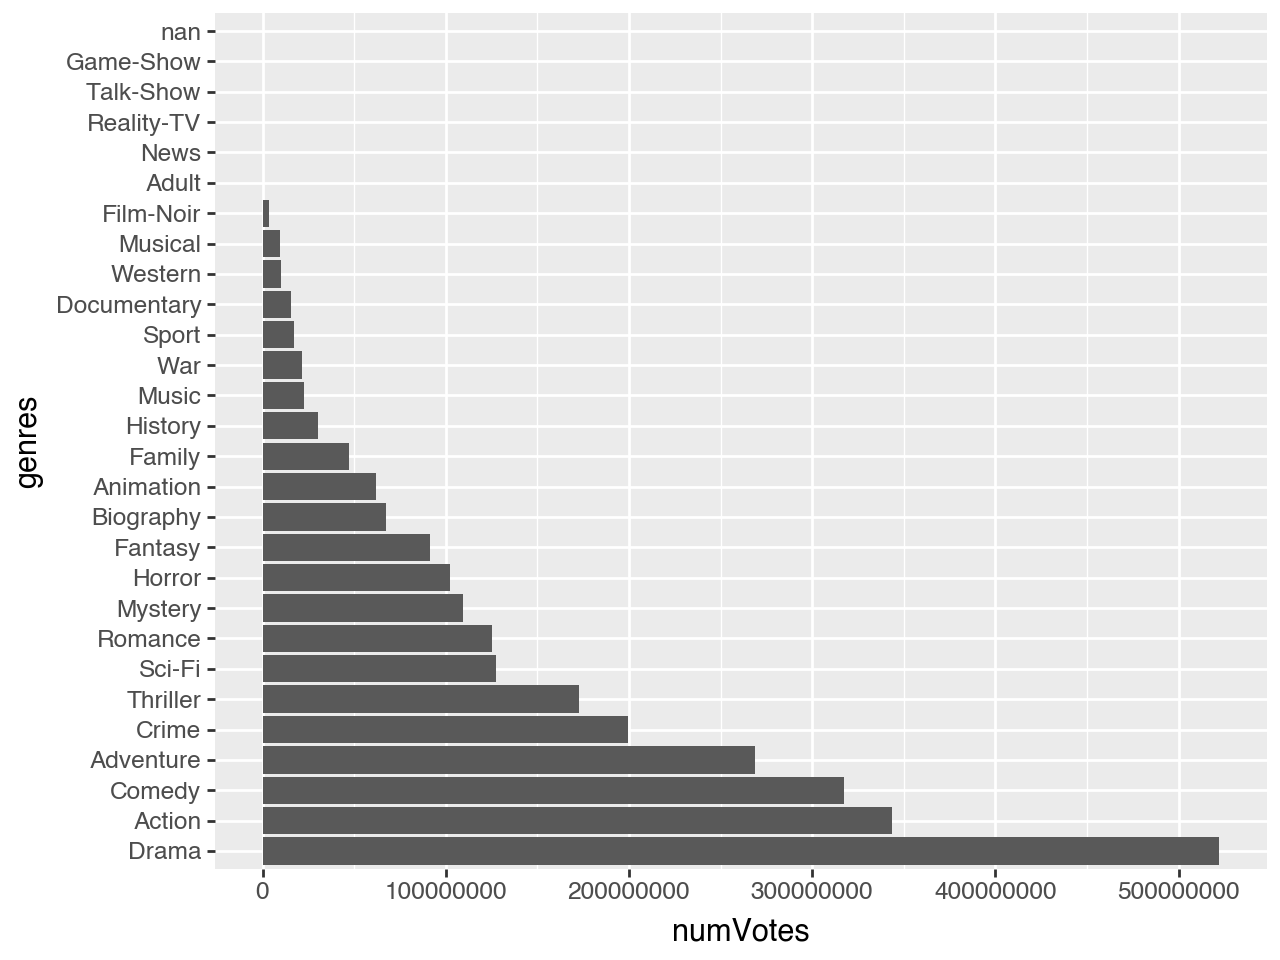

In [43]:
(
    p9.ggplot(tgr_gp, p9.aes(x="genres", y="numVotes"))
    + p9.geom_bar(stat="identity")
    + p9.coord_flip()
)

In [121]:
genres = (
    titles.select(["tconst", "genres"])
    .explode("genres")
    .to_dummies("genres")
    .group_by("tconst")
    .agg(pl.all().sum().cast(pl.UInt8))
)
title_genres = titles.join(genres, on="tconst", how="left")
title_genres.head()

tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,genres_Action,genres_Adult,genres_Adventure,genres_Animation,genres_Biography,genres_Comedy,genres_Crime,genres_Documentary,genres_Drama,genres_Family,genres_Fantasy,genres_Film-Noir,genres_Game-Show,genres_History,genres_Horror,genres_Music,genres_Musical,genres_Mystery,genres_News,genres_Reality-TV,genres_Romance,genres_Sci-Fi,genres_Short,genres_Sport,genres_Talk-Show,genres_Thriller,genres_War,genres_Western,genres_null
str,cat,str,str,i64,i64,i64,i64,list[str],u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8
"""tt0000001""","""short""","""Carmencita""","""Carmencita""",0,1894,null,1,"[""Documentary"", ""Short""]",0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
"""tt0000002""","""short""","""Le clown et se…","""Le clown et se…",0,1892,null,5,"[""Animation"", ""Short""]",0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
"""tt0000003""","""short""","""Pauvre Pierrot…","""Pauvre Pierrot…",0,1892,null,5,"[""Animation"", ""Comedy"", ""Romance""]",0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
"""tt0000004""","""short""","""Un bon bock""","""Un bon bock""",0,1892,null,12,"[""Animation"", ""Short""]",0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
"""tt0000005""","""short""","""Blacksmith Sce…","""Blacksmith Sce…",0,1893,null,1,"[""Comedy"", ""Short""]",0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [122]:
tgr = title_genres.join(ratings, on="tconst", how="left")

In [112]:
genres.head()

tconst,genres_Action,genres_Adult,genres_Adventure,genres_Animation,genres_Biography,genres_Comedy,genres_Crime,genres_Documentary,genres_Drama,genres_Family,genres_Fantasy,genres_Film-Noir,genres_Game-Show,genres_History,genres_Horror,genres_Music,genres_Musical,genres_Mystery,genres_News,genres_Reality-TV,genres_Romance,genres_Sci-Fi,genres_Short,genres_Sport,genres_Talk-Show,genres_Thriller,genres_War,genres_Western,genres_null
str,list[u8],list[u8],list[u8],list[u8],list[u8],list[u8],list[u8],list[u8],list[u8],list[u8],list[u8],list[u8],list[u8],list[u8],list[u8],list[u8],list[u8],list[u8],list[u8],list[u8],list[u8],list[u8],list[u8],list[u8],list[u8],list[u8],list[u8],list[u8],list[u8]
null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null


In [101]:
unique_column_values = title_ratings2.select(pl.col("genres")).unique()

In [103]:
unique_column_values

genres
str
"""Crime"""
"""Music"""
"""Film-Noir"""
"""Animation"""
"""Talk-Show"""
"""News"""
"""Short"""
"""War"""
"""Reality-TV"""


In [ ]:
aggregate_function = lambda col: col.tanh().mean()

df.lazy().group_by(index).agg(
    aggregate_function(values.filter(on == value)).alias(value)
    for value in unique_column_values
).collect().pivot("genres")

In [20]:
title_ratings1.head()

tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
str,cat,str,str,i64,i64,i64,i64,str,f64,i64
"""tt0000001""","""short""","""Carmencita""","""Carmencita""",0,1894,null,1,"""Documentary""",5.7,2074
"""tt0000001""","""short""","""Carmencita""","""Carmencita""",0,1894,null,1,"""Short""",5.7,2074
"""tt0000002""","""short""","""Le clown et se…","""Le clown et se…",0,1892,null,5,"""Animation""",5.6,279
"""tt0000002""","""short""","""Le clown et se…","""Le clown et se…",0,1892,null,5,"""Short""",5.6,279
"""tt0000003""","""short""","""Pauvre Pierrot…","""Pauvre Pierrot…",0,1892,null,5,"""Animation""",6.5,2066


In [48]:
data_splitter = pl.Series(
    "data",
    np.where(
        np.random.default_rng(42).random(len(title_ratings)) < 0.9, "train", "test"
    ),
)
# <0.1,"train","test"))

In [49]:
title_ratings = title_ratings.insert_column(-1, data_splitter)

In [50]:
train = title_ratings.filter(pl.col("data") == "train")

In [51]:
train.shape

(768140, 12)

# EDA

## Ratings and NumVotes

The reliability of the ratings depend on how many people voted. We would expect films with only a handful of votes to have a wider range than films with millions of votes.  Also there is a bias - films with many votes are unlikely to be bad films.

The original user data is a score from 1 - 10.  The data is summarised as an average rating, together with the number of votes.  Num votes is an incomplete estimate of the variability of the mean eg an average rating of 5.5 with 10 people and votes of 1-10, vs 10 people voting .  What we need is the standard deviation (or equivalent) of the original votes as well as just the counts.

We use weighted regression to incorporate the counts ( and the regression assumes a common standard deviation)

An ordinal regression would be a natural fit for the individual user data.  A Beta regression would ensure values only between 0 and 1.
Standard tree based methods like gradient boosting do not extrapolate, and would ensure the 1-10 limit.



shape: (9, 2)
┌────────────┬──────────┐
│ describe   ┆ numVotes │
│ ---        ┆ ---      │
│ str        ┆ f64      │
╞════════════╪══════════╡
│ count      ┆ 429864.0 │
│ null_count ┆ 423704.0 │
│ mean       ┆ 1.823258 │
│ std        ┆ 0.764065 │
│ min        ┆ 0.69897  │
│ 25%        ┆ 1.255273 │
│ 50%        ┆ 1.662758 │
│ 75%        ┆ 2.212188 │
│ max        ┆ 6.466885 │
└────────────┴──────────┘


/Users/seanviolante/miniforge3/envs/ML/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_bin : Removed 49556 rows containing non-finite values.


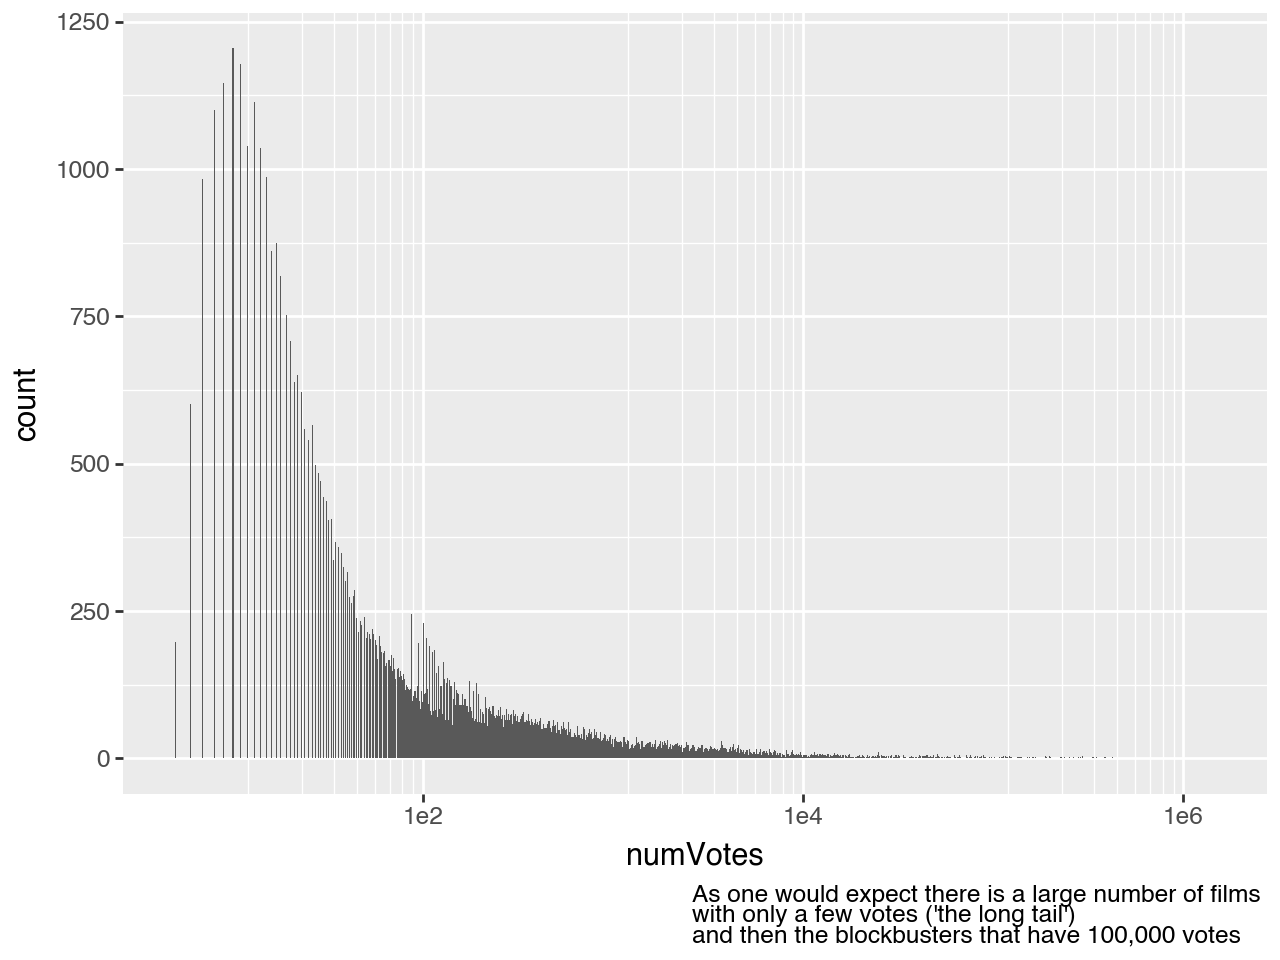

In [162]:
print(title_ratings.select(pl.col("numVotes").log10()).describe())
(
    p9.ggplot(title_ratings.sample(100_000), p9.aes(x="numVotes"))
    + p9.geom_histogram(bins=1000)
    + p9.scale_x_log10()
    + p9.labs(
        caption="As one would expect there is a large number of films \nwith only a few votes ('the long tail') \nand then the blockbusters that have 100,000 votes"
    )
)

/Users/seanviolante/miniforge3/envs/ML/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_tile : Removed 49632 rows containing missing values.


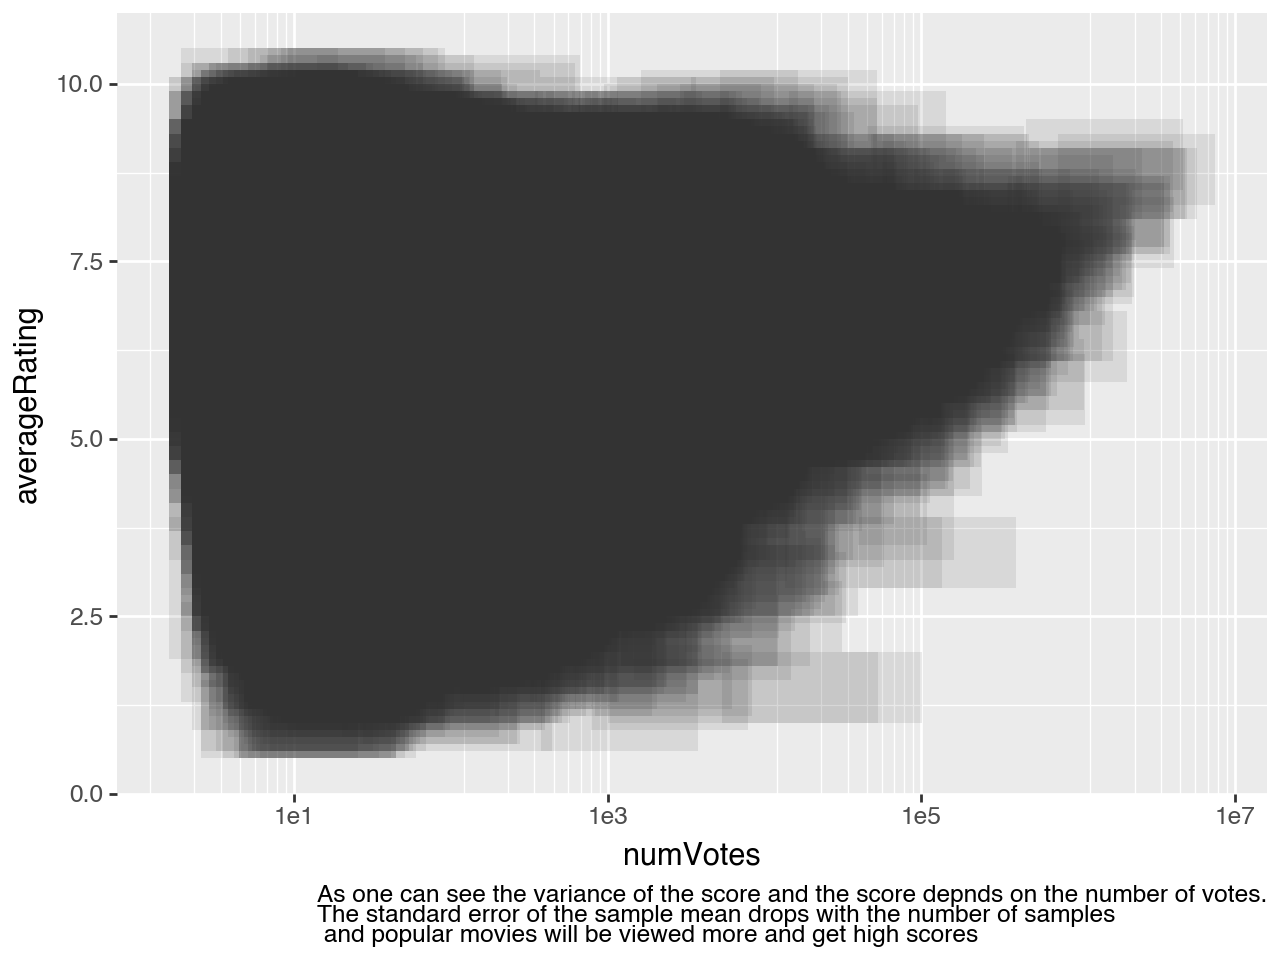

In [163]:
(
    p9.ggplot(title_ratings.sample(100_000), p9.aes(x="numVotes", y="averageRating"))
    + p9.geom_tile(alpha=0.1)
    + p9.scale_x_log10()
    + p9.labs(
        caption="As one can see the variance of the score and the score depnds on the number of votes.\nThe standard error of the sample mean drops with the number of samples\n and popular movies will be viewed more and get high scores"
    )
)

shape: (9, 2)
┌────────────┬───────────────┐
│ describe   ┆ averageRating │
│ ---        ┆ ---           │
│ str        ┆ f64           │
╞════════════╪═══════════════╡
│ count      ┆ 429864.0      │
│ null_count ┆ 423704.0      │
│ mean       ┆ 6.678464      │
│ std        ┆ 1.29481       │
│ min        ┆ 1.0           │
│ 25%        ┆ 5.9           │
│ 50%        ┆ 6.9           │
│ 75%        ┆ 7.6           │
│ max        ┆ 10.0          │
└────────────┴───────────────┘


/Users/seanviolante/miniforge3/envs/ML/lib/python3.11/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 252'. Pick better value with 'binwidth'.
/Users/seanviolante/miniforge3/envs/ML/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_bin : Removed 423704 rows containing non-finite values.


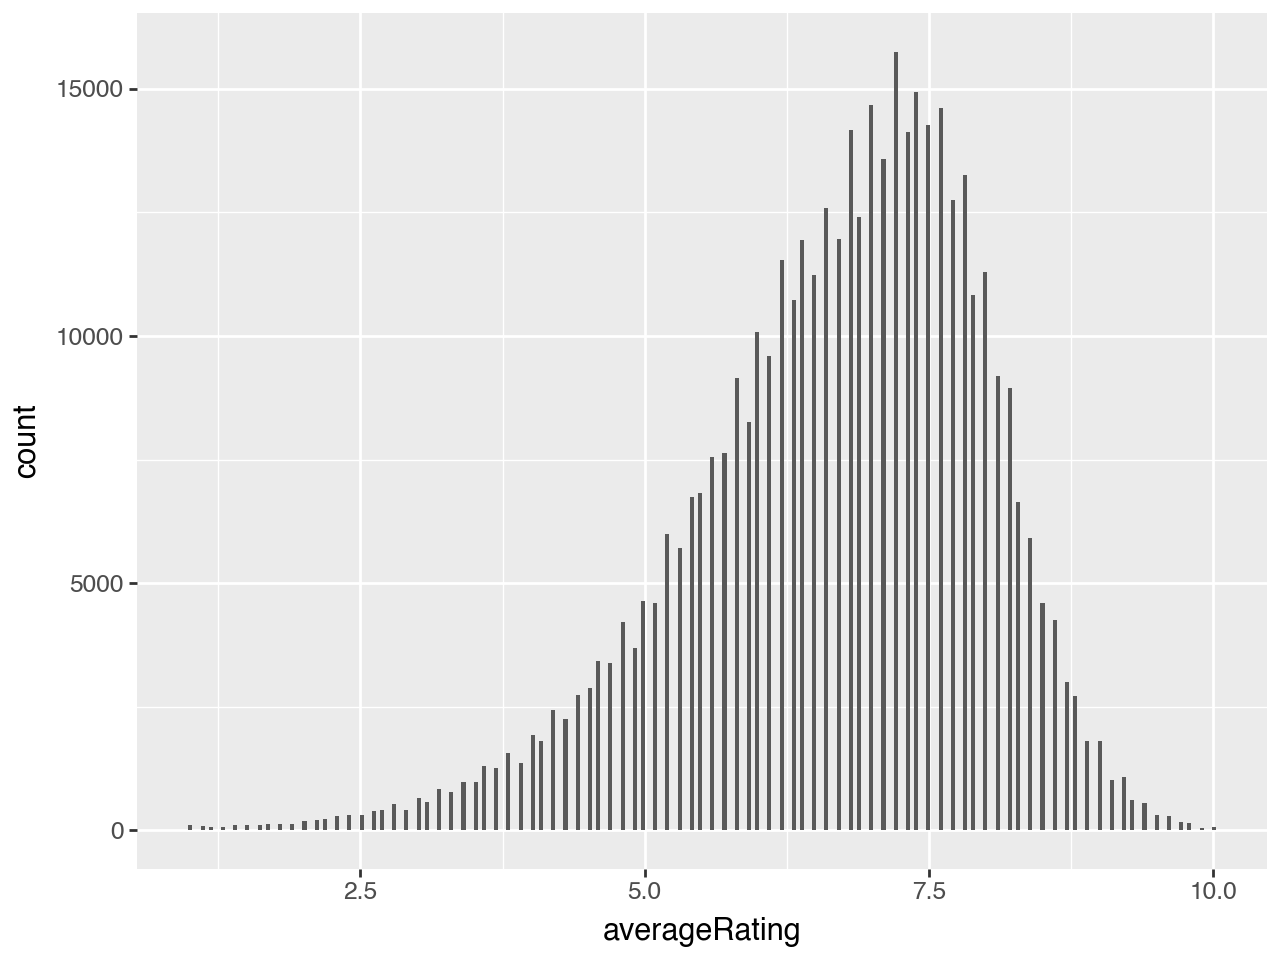

In [164]:
print(title_ratings.select("averageRating").describe())
p9.ggplot(title_ratings, p9.aes(x="averageRating")) + p9.geom_histogram()

In [191]:
params = stats.beta.fit(ratings.select("averageRating").drop_nulls() - 1)

/Users/seanviolante/miniforge3/envs/ML/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.


In [192]:
from functools import partial

beta_pdf = partial(
    stats.beta.pdf, a=params[0], b=params[1], loc=params[2], scale=params[3]
)
params

(413673.84066553763,
 10.413046311389422,
 -174948.66163400962,
 174959.01861322875)

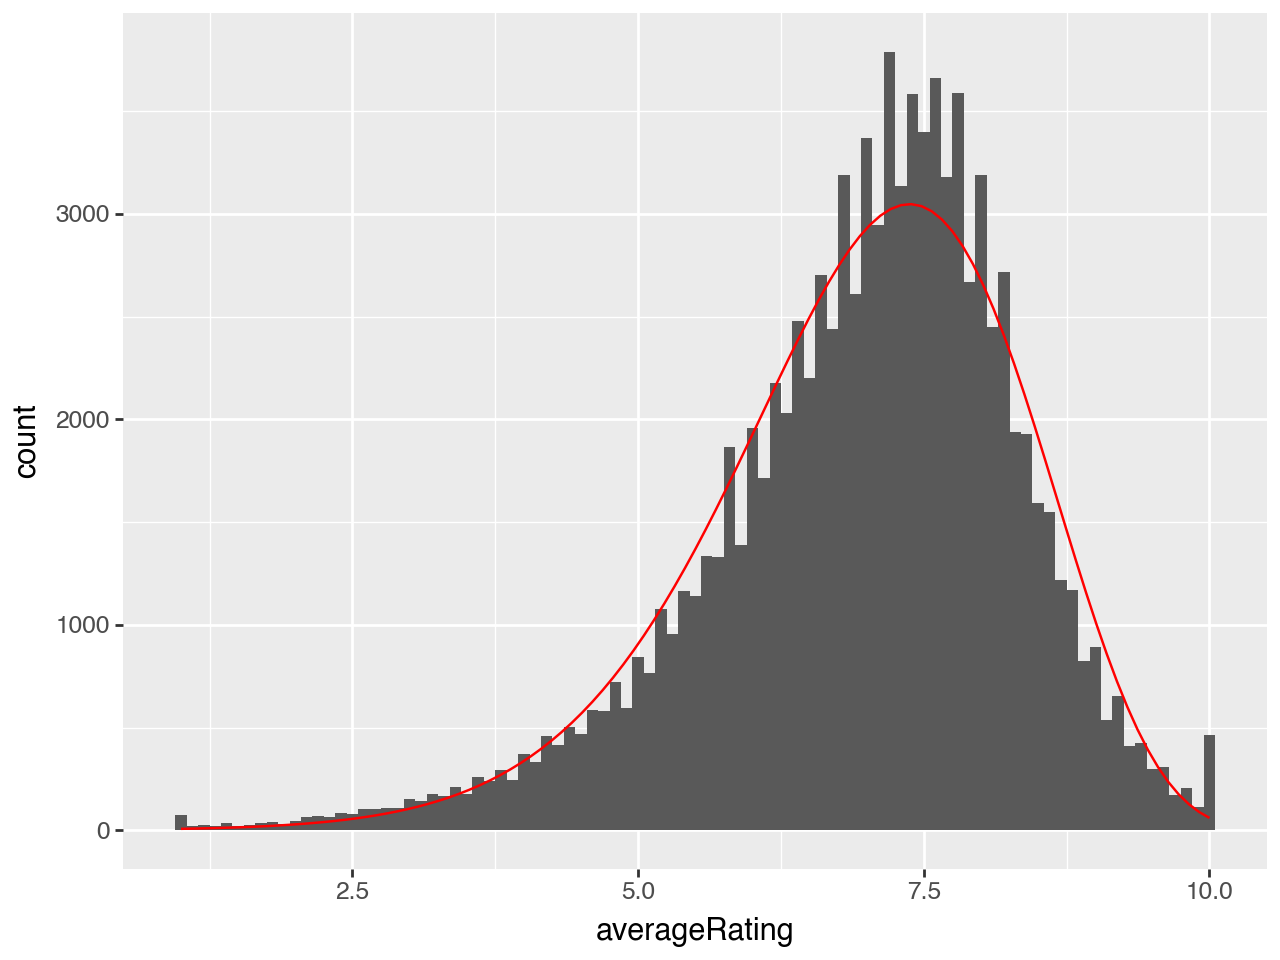

In [194]:
(
    p9.ggplot(
        (ratings.sample(100_000).select("averageRating")), p9.aes(x="averageRating")
    )
    + p9.geom_histogram(binwidth=0.1)
    + p9.stat_function(fun=lambda x: beta_pdf(x - 1) * 100_000 * 0.1, colour="red")
)

Ratings are centred 

In [52]:
train.head()

tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,data,numVotes
str,cat,str,str,i64,i64,i64,i64,list[str],f64,str,i64
"""tt0000001""","""short""","""Carmencita""","""Carmencita""",0,1894,null,1,"[""Documentary"", ""Short""]",5.7,"""train""",2074
"""tt0000002""","""short""","""Le clown et se…","""Le clown et se…",0,1892,null,5,"[""Animation"", ""Short""]",5.6,"""train""",279
"""tt0000003""","""short""","""Pauvre Pierrot…","""Pauvre Pierrot…",0,1892,null,5,"[""Animation"", ""Comedy"", ""Romance""]",6.5,"""train""",2066
"""tt0000004""","""short""","""Un bon bock""","""Un bon bock""",0,1892,null,12,"[""Animation"", ""Short""]",5.4,"""train""",180
"""tt0000005""","""short""","""Blacksmith Sce…","""Blacksmith Sce…",0,1893,null,1,"[""Comedy"", ""Short""]",6.2,"""train""",2810


In [57]:
ratings_year = (
    title_ratings.group_by("startYear")
    .agg(
        (
            (pl.col("averageRating") * pl.col("numVotes")).sum()
            / pl.col("numVotes").sum()
        ).alias("averageRating"),
        pl.col("runtimeMinutes").mean(),
        pl.col("numVotes").sum().alias("numVotes_sum"),
        pl.col("numVotes").mean().alias("numVotes_mean"),
    )
    .sort("startYear")
)

/Users/seanviolante/miniforge3/envs/ML/lib/python3.11/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/seanviolante/miniforge3/envs/ML/lib/python3.11/site-packages/plotnine/geoms/geom_path.py:100: PlotnineWarning: geom_path: Removed 1 rows containing missing values.


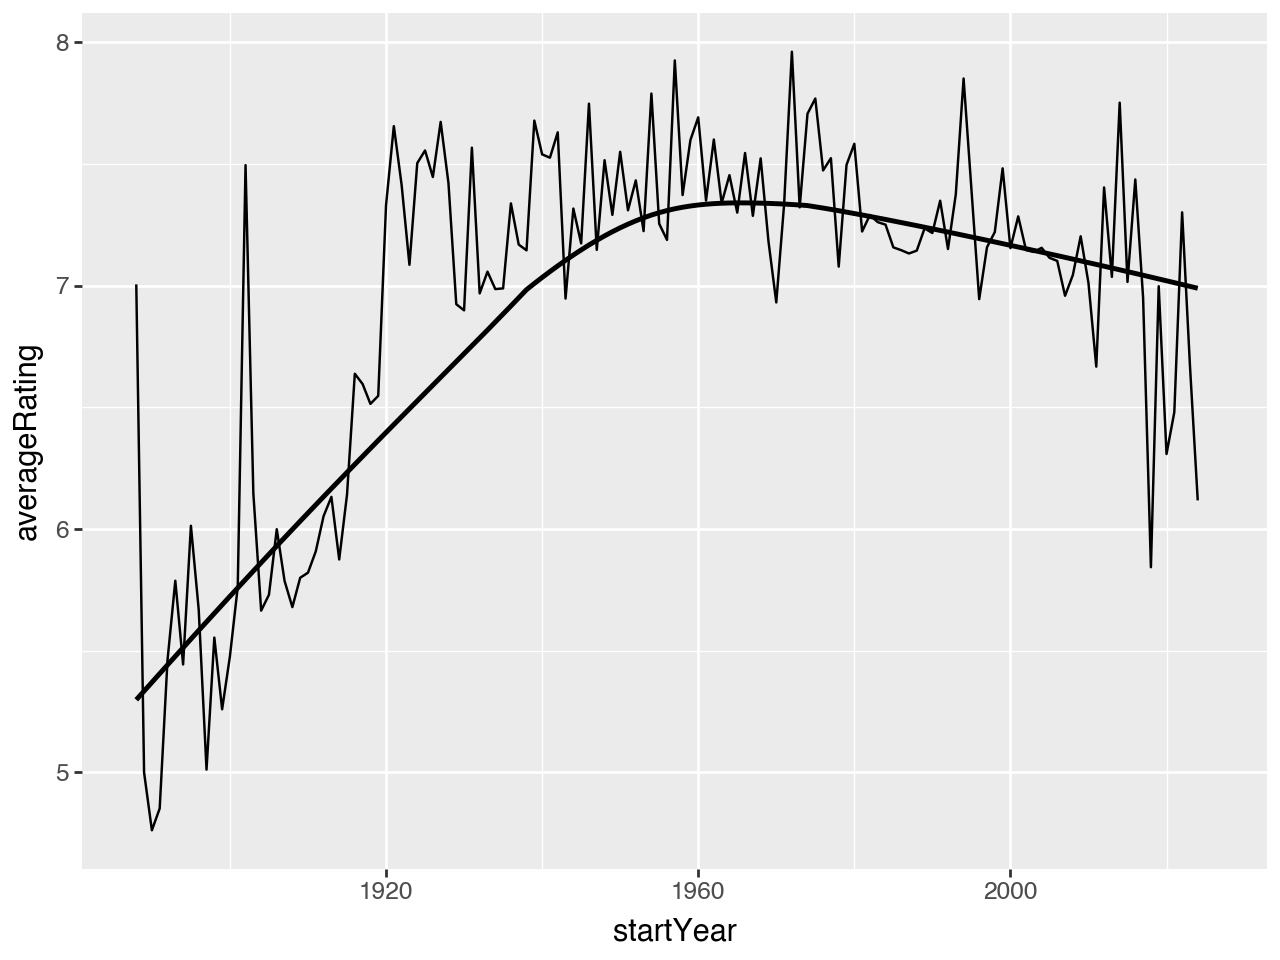

In [61]:
(
    p9.ggplot(ratings_year, p9.aes(x="startYear", y="averageRating"))
    + p9.geom_line()
    + p9.geom_smooth()
)

In [14]:
title_ratings.select("titleType").unique()

titleType
cat
"""short"""
"""movie"""
"""tvShort"""
"""tvMovie"""
"""tvEpisode"""
"""tvSeries"""
"""tvMiniSeries"""
"""tvSpecial"""
"""video"""


In [58]:
minutes = (
    title_ratings_train.group_by("runtimeMinutes")
    .agg(
        averageRating=(pl.col("averageRating") * pl.col("numVotes")).sum()
        / pl.col("numVotes").sum(),
        numStars=(pl.col("averageRating") * pl.col("numVotes")).sum(),
        stdevRating=((pl.col("averageRating") ** 2) * pl.col("numVotes")).sum()
        / pl.col("numVotes").sum(),  # mean X^2
        numVotes=pl.col("numVotes").sum(),
        numFilms=pl.count(),
    )
    .with_columns(
        averageRating_smooth=(
            pl.col("averageRating") * pl.col("numVotes")
            + (pl.col("averageRating") * pl.col("numVotes")).sum()
            / pl.col("numVotes").sum()
            * 10
        )
        / (pl.col("numVotes") + 10),
        stdevRating=(pl.col("stdevRating") - pl.col("averageRating") ** 2).sqrt(),
    )
).sort("numStars", descending=True)

/var/folders/3l/w934tqys1nzdhghynnjh0lxc0000gn/T/ipykernel_71546/560655808.py:11: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.


/Users/seanviolante/miniforge3/envs/ML/lib/python3.11/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/seanviolante/miniforge3/envs/ML/lib/python3.11/site-packages/plotnine/geoms/geom_path.py:100: PlotnineWarning: geom_path: Removed 1 rows containing missing values.


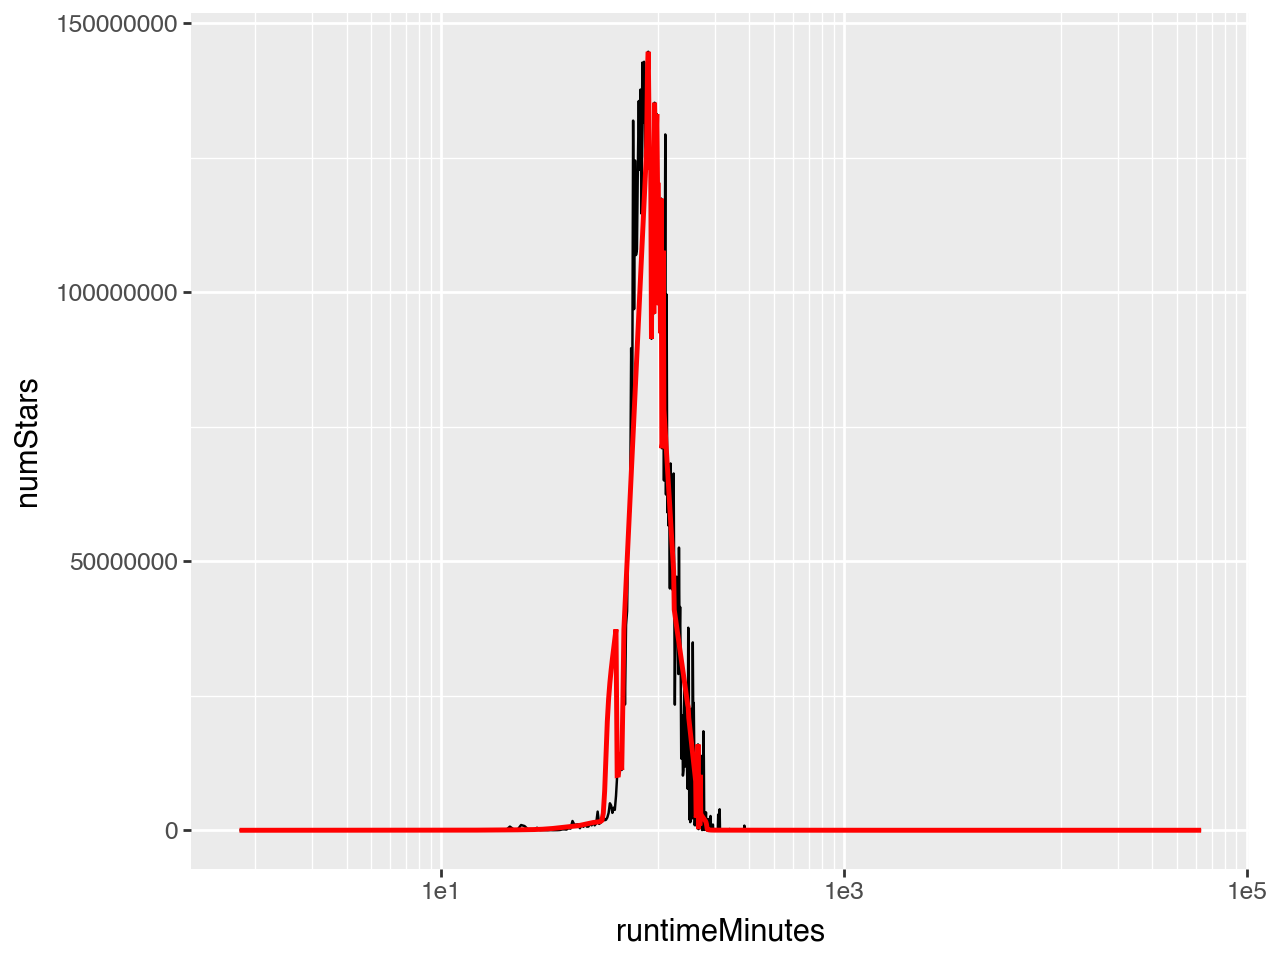

/Users/seanviolante/miniforge3/envs/ML/lib/python3.11/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/seanviolante/miniforge3/envs/ML/lib/python3.11/site-packages/plotnine/geoms/geom_path.py:100: PlotnineWarning: geom_path: Removed 1 rows containing missing values.


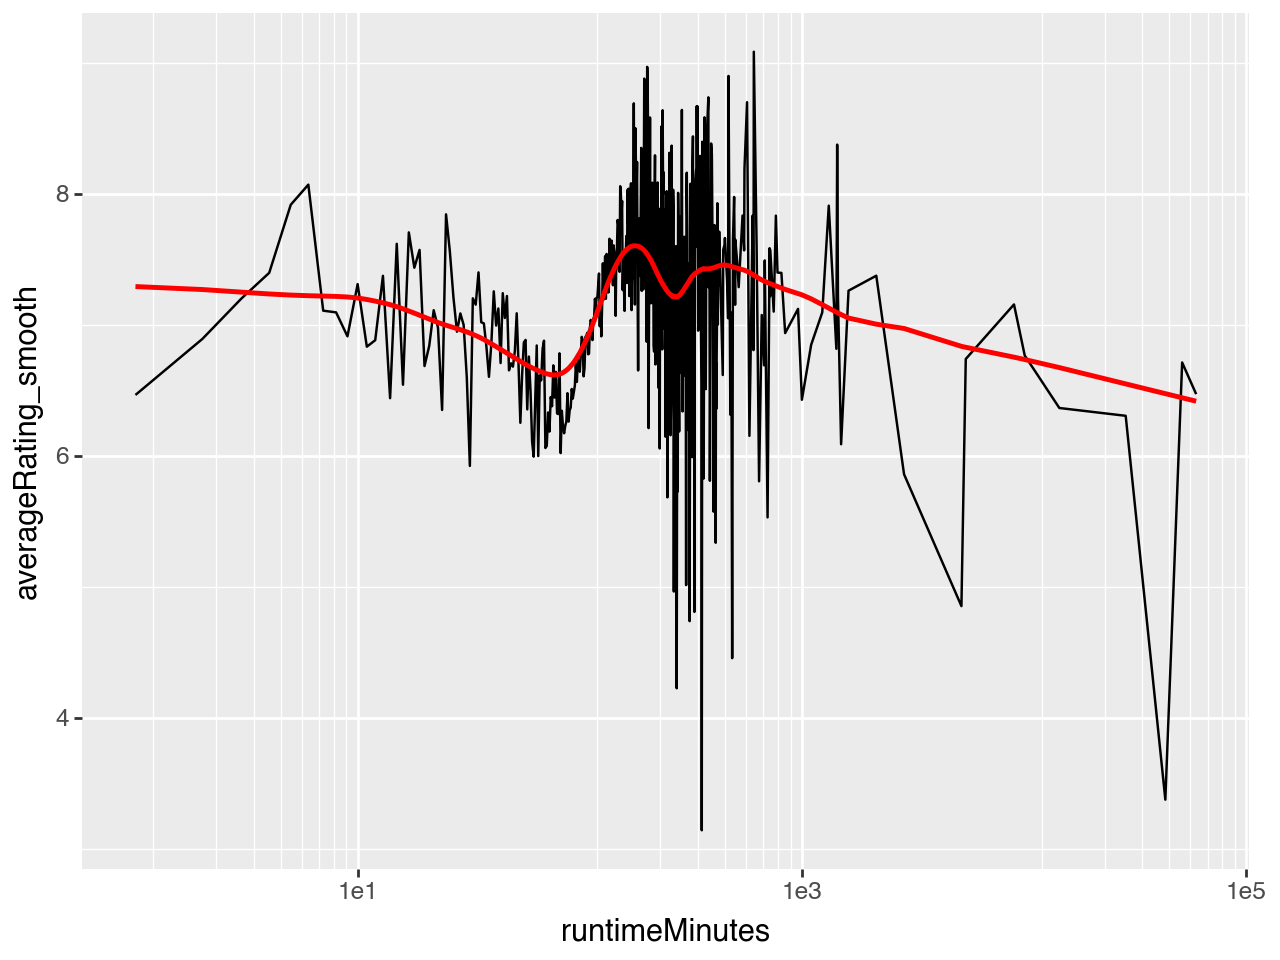

In [62]:
(
    p9.ggplot(minutes, p9.aes(x="runtimeMinutes", y="numStars"))
    + p9.geom_line()
    + p9.scale_x_log10()
    + p9.geom_smooth(span=0.1, color="red")
).show()
(
    p9.ggplot(minutes, p9.aes(x="runtimeMinutes", y="averageRating_smooth"))
    + p9.geom_line()
    + p9.scale_x_log10()
    + p9.geom_smooth(span=0.3, color="red")
).show()

In [11]:
y_cols = ["averageRating", "numVotes"]
X = title_ratings.select(pl.exclude(y_cols))

In [ ]:
# %%
filter movie endyear->, runtimeMinutes, genres 
titles1 = titles.




# Train Model

In [295]:
X_train.head()

tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
str,cat,str,str,i64,i64,i64,i64,list[str]
"""tt0763252""","""tvEpisode""","""Like a Virgin""","""Like a Virgin""",0,1997,null,22,"[""Comedy"", ""Romance""]"
"""tt0227471""","""tvSeries""","""Senza rete""","""Senza rete""",0,1968,null,null,null
"""tt0750064""","""tvEpisode""","""Jeanette""","""Jeanette""",0,2002,null,47,"[""Action"", ""Crime"", ""Drama""]"
"""tt0690624""","""tvEpisode""","""Episode #5.19""","""Episode #5.19""",0,2004,null,73,"[""Comedy"", ""Talk-Show""]"
"""tt0357438""","""video""","""The Arrangemen…","""The Arrangemen…",1,2002,null,90,"[""Adult"", ""Crime"", ""Drama""]"


In [299]:
X_train_dummy = X_train.with_columns(genres=pl.col("genres").list.join(separator="|"))
X_train_dummy_pd = X_train_dummy.to_pandas()

In [302]:
X_train_dummies = X_train_dummy_pd.genres.str.get_dummies()

In [314]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer(sparse_output=True)
zz = X_train.get_column("genres")

In [ ]:
make csr matrix in polars by exploding and indexing row/columns -> i,j, value

In [316]:
X_train_dummies1 = mlb.fit_transform(zz.drop_nulls())

In [318]:
type(X_train_dummies1)

scipy.sparse._csr.csr_matrix

In [305]:
X_train_dummies.dtypes

Action         int64
Adult          int64
Adventure      int64
Animation      int64
Biography      int64
Comedy         int64
Crime          int64
Documentary    int64
Drama          int64
Family         int64
Fantasy        int64
Film-Noir      int64
Game-Show      int64
History        int64
Horror         int64
Music          int64
Musical        int64
Mystery        int64
News           int64
Reality-TV     int64
Romance        int64
Sci-Fi         int64
Short          int64
Sport          int64
Talk-Show      int64
Thriller       int64
War            int64
Western        int64
dtype: object

In [ ]:
# %%
Xy = xgb.DMatrix(X_, y, enable_categorical=True)
booster = xgb.train({"tree_method": "hist", "max_cat_to_onehot": 5}, Xy)

# Junk

In [ ]:
# %%
titles_read = pl.read_csv_batched(
    "data/title.basics.tsv",
    separator="\t",
    null_values="\\N",
    dtypes={"endYear": int, "genres": str},
)

dfs = []
batches = titles_read.next_batches(5000)
try:
    for i_batch, batch in enumerate(batches):
        dfs[i_batch] = batch
except Exception as e:
    print(f"failed on {i_batch}")
    print(e)